In [1]:
%matplotlib inline
import matplotlib.pyplot as plt


import os
import itertools
import json
import numpy as np
import pandas as pd
import pickle
import requests
import seaborn as sns
import collections
from collections import Counter
import scipy
import time
import copy
from collections import OrderedDict

import matplotlib as mpl
import matplotlib.gridspec as gridspec
from matplotlib.patches import Rectangle
import matplotlib.patches as mpatches

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition.pca import PCA
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn import clone

import nltk
#nltk.download('wordnet')
#nltk.download('stopwords')
#nltk.download('punkt')
#nltk.download('averaged_perceptron_tagger')
import gensim
import re
from fuzzywuzzy import process
import networkx as nx


/Users/stefgarasto/miniconda3/envs/nlp/lib/python3.6/site-packages/smart_open/ssh.py:34: UserWarning: paramiko missing, opening SSH/SCP/SFTP paths will be disabled.  `pip install paramiko` to suppress
  warnings.warn('paramiko missing, opening SSH/SCP/SFTP paths will be disabled.  `pip install paramiko` to suppress')


In [2]:
from utils_nos import nesta_colours, nesta_colours_combos
print(nesta_colours, nesta_colours_combos)


[[1, 0.7215686274509804, 0.09803921568627451], [1, 0, 0.2549019607843137], [0, 0, 0], [1, 0.35294117647058826, 0], [0.6078431372549019, 0, 0.7647058823529411], [0.6470588235294118, 0.5803921568627451, 0.5098039215686274], [0.6274509803921569, 0.5686274509803921, 0.1568627450980392], [0.7686274509803922, 0.6901960784313725, 0], [0.9647058823529412, 0.49411764705882355, 0], [0.7843137254901961, 0.1568627450980392, 0.5725490196078431], [0.23529411764705882, 0.07058823529411765, 0.3215686274509804]] [[0, 1, 2, 3, 4, 5], [0, 6, 7], [1, 3, 8], [4, 9, 10], [8, 5], [1, 11]]


In [3]:
# set up plot style
print(plt.style.available)
plt.style.use(['seaborn-darkgrid','seaborn-poster','ggplot'])


['seaborn-dark', 'seaborn-darkgrid', 'seaborn-ticks', 'fivethirtyeight', 'seaborn-whitegrid', 'classic', '_classic_test', 'fast', 'seaborn-talk', 'seaborn-dark-palette', 'seaborn-bright', 'seaborn-pastel', 'grayscale', 'seaborn-notebook', 'ggplot', 'seaborn-colorblind', 'seaborn-muted', 'seaborn', 'Solarize_Light2', 'seaborn-paper', 'bmh', 'tableau-colorblind10', 'seaborn-white', 'dark_background', 'seaborn-poster', 'seaborn-deep']


In [4]:
# flatten lists of lists
def flatten_lol(t):
    return list(itertools.chain.from_iterable(t))
flatten_lol([[1,2],[3],[4,5,6]])

def print_elapsed(t0_local, task = 'current task'):
    print('Done with {}. Elapsed time: {:4f}'.format(task,time.time()-t0_local))
    

In [5]:
#These two functions are useful for analysing bi and tri-grams with w2v models in gensim

def convert_to_undersc(skill):
    '''
    convert spaces in skill phrases into underscores to use with trained
    w2v model.
    '''
    if len(skill.split(' ')) >1:
        new_i = '-'.join(skill.split(' '))
    else:
        new_i = skill
    return(new_i)

def convert_from_undersc(skill):
    '''
    convert underscores between terms in skill phrases back to spaces.
    '''
    if len(skill.split('_')) >1:
        new_i = ' '.join(skill.split('_'))
    else:
        new_i = skill
    return(new_i)


#A few functions for tyding up text
def tag_for_lemmatise(s):
    pos_to_wornet_dict = {
        'JJ': 'a',
        'JJR': 'a',
        'JJS': 'a',
        'RB': 'r',
        'RBR': 'r',
        'RBS': 'r',
        'NN': 'n',
        'NNP': 'n',
        'NNS': 'n',
        'NNPS': 'n',
        'VB': 'v',
        'VBG': 'v',
        'VBD': 'v',
        'VBN': 'v',
        'VBP': 'v',
        'VBZ': 'v',
    }
    try:
        return pos_to_wornet_dict[nltk.pos_tag([s])[0][1]]
    except:
        return 'n'
    
def lemmatise(title_terms):
    """
    Takes list as input.
    Removes suffixes if the new words exists in the nltk dictionary.
    The purpose of the function is to convert plural forms into singular.
    Allows some nouns to remain in plural form (the to_keep_asis is manually curated).
    Returns a list.
    >>> lemmatise(['teachers'])
    ['teacher']
    >>> lemmatise(['analytics'])
    ['analytics']
    """
    keep_asis = ['sales', 'years', 'goods', 'operations', 'systems',
                    'communications', 'events', 'loans', 'grounds',
                    'lettings', 'claims', 'accounts', 'relations',
                    'complaints', 'services']
    wnl = nltk.WordNetLemmatizer()
    processed_terms = [wnl.lemmatize(i) if i not in keep_asis else i for i in title_terms]
    #processed_terms = [wnl.lemmatize(i, pos = tag_for_lemmatise(i)) 
    #            if i not in keep_asis else i for i in title_terms]
    return processed_terms

def lemmatise_with_pos(title_terms):
    """
    Takes list as input.
    Removes suffixes if the new words exists in the nltk dictionary.
    The purpose of the function is to convert plural forms into singular.
    Allows some nouns to remain in plural form (the to_keep_asis is manually curated).
    Returns a list.
    >>> lemmatise(['teachers'])
    ['teacher']
    >>> lemmatise(['analytics'])
    ['analytics']
    """
    pos_to_wornet_dict = {
        'JJ': 'a',
        'JJR': 'a',
        'JJS': 'a',
        'RB': 'r',
        'RBR': 'r',
        'RBS': 'r',
        'NN': 'n',
        'NNP': 'n',
        'NNS': 'n',
        'NNPS': 'n',
        'VB': 'v',
        'VBG': 'v',
        'VBD': 'v',
        'VBN': 'v',
        'VBP': 'v',
        'VBZ': 'v',
    }
    keep_asis = ['sales', 'years', 'goods', 'operations', 'systems',
                    'communications', 'events', 'loans', 'grounds',
                    'lettings', 'claims', 'accounts', 'relations',
                    'complaints', 'services']
    wnl = nltk.WordNetLemmatizer()
    processed_terms = [wnl.lemmatize(i, pos_to_wornet_dict[p]) 
                       if i not in keep_asis else i for i,p in title_terms]
    #processed_terms = [wnl.lemmatize(i, pos = tag_for_lemmatise(i)) 
    #            if i not in keep_asis else i for i in title_terms]
    return processed_terms

def lemmatise_pruned(x, pofs = 'nv'):
    if pofs == 'nv':
        tags = [(t,p) for t,p in x if p[:1] in ['V','N']]
    elif pofs == 'n':
        tags = [(t,p) for t,p in x if p[:1] in ['N']]
    else:
        raise ValueError
    return lemmatise_with_pos(tags)

def remove_digits(s):
    """
    Takes a string as input.
    Removes digits in a string.
    Returns a string.
    >>> remove_digits('2 recruitment consultants')
    ' recruitment consultants'
    """
    result = ''.join(i for i in s if not i.isdigit())
    return result

def remove_list_enumeration(s):
    '''
    This is a specific requirement of the NOS that comes from
    the presence of lists enumerated by strings like K+number
    or P+number. Therefore, after "lowerising" and removing 
    digits, I look for and remove strings like "k " and "p "
    '''
    result = re.sub('( k )+',' ',s)
    result = re.sub('( p )+', ' ', result)
    # it might not be necessary if I add 'k' and 'p' to stopwords
    return result

select_punct = set('!"#$%&\()*+,-./:;<=>?@[\\]^_`{|}~') #only removed "'"
extra_chars = set('–-•’”“µ¾âãéˆﬁ[€™¢±ï…˜')
all_select_chars = select_punct.union(extra_chars)
def replace_punctuation(s):
    """
    Takes string as input.
    Removes punctuation from a string if the character is in select_punct.
    Returns a string.
   >>> replace_punctuation('sales executives/ - london')
   'sales executives   london'
    """
    for i in set(all_select_chars): #set(select_punct):
        if i in s:
            s = s.replace(i, ' ')
    return s

def tidy_desc(desc):
    clean_data = desc.replace('\r\n', '').replace('\xa0', '')
    nodigits = remove_digits(clean_data.lower())
    nopunct = replace_punctuation(nodigits)
    #nopunct = remove_list_enumeration(nopunct)
    lemm = lemmatise(nopunct.split())
    return ' '.join(lemm)

def tokenize(text):
    """
    Takes string as input.
    Returns list of tokens. The function is used as an argument for
    TfidfVectorizer.
    >>> tokenize('some job title')
    ['some', 'job', 'title']
    """
    tokens = nltk.word_tokenize(text)
    return tokens

def tokenize_asis(some_list):
    """
    Takes list as input.
    Returns the list with elements converted to lower case. The function is 
    used as an argument for TfidfVectorizer.
    
    In [57]: tokenize(['Accounting', 'Microsoft Excel'])
    Out[57]: ['accounting', 'microsoft excel']
    """
    tokens = [elem.lower() for elem in some_list]
    return tokens


#This set of functions is useful for identifying terms with highest tf-idf weights 
#in a single document or set of documents

def top_tfidf_feats(row, features, top_n=25):
    ''' Get top n tfidf values in row and return them with their corresponding 
        feature names.'''
    topn_ids = np.argsort(row)[::-1][:top_n]
    top_feats = [(features[i], row[i]) for i in topn_ids]
    df = pd.DataFrame(top_feats)
    df.columns = ['feature', 'tfidf']
    return df

def top_mean_feats(Xtr, features, grp_ids=None, min_tfidf=0.1, top_n=25, sparse_output = False):
    ''' Return the top n features that on average are most important 
        amongst documents in rows
        indentified by indices in grp_ids. '''
    if grp_ids:
        D = Xtr[grp_ids].toarray()
    else:
        D = Xtr.toarray()

    D[D < min_tfidf] = 0
    tfidf_means = np.mean(D, axis=0)
    if sparse_output:
        return scipy.sparse.csr_matrix(top_tfidf_feats(tfidf_means, features, top_n))
    else:
        return top_tfidf_feats(tfidf_means, features, top_n)

def all_mean_feats(Xtr, grp_ids=None, min_tfidf=0.1):
    ''' Return the average
        amongst documents in rows
        indentified by indices in grp_ids. '''
    if grp_ids:
        D = Xtr[grp_ids].toarray()
    else:
        D = Xtr.toarray()

    D[D < min_tfidf] = 0
    tfidf_means = np.mean(D, axis=0)
    return tfidf_means

def get_top_words_weights(desc, feature_names, vect, n = 25):
    response = vect.transform(desc)
    words = top_mean_feats(response, feature_names, grp_ids = None, top_n = n)
    return words

def get_mean_tfidf(desc, vect):
    response = vect.transform(desc)
    tfidf_values = all_mean_feats(response, grp_ids = None)
    return tfidf_values

def get_top_words(desc, feature_names, vect, n = 25):
    response = vect.transform(desc)
    words = top_mean_feats(response, feature_names, grp_ids = None, top_n = n)
    return words['feature'].values


# manually remove "k"s and "p"s from the pruned columns
def remove_pk(x):
    return [t for t in x if t not in ['k','p']]
#df_nos['pruned'] = df_nos['pruned'].map(remove_pk)


### Define more functions on how to create the TfIdf vectoriser and matrix

In [6]:
# First, create your TFidfVectorizer model. This doesn't depend on whether it's used on suites or NOS. However,
# it does require that the docs collection is already given as a collection of tokens (tokenizer=tokenize_asis)

#Since we now have not just long strings in our documents, but lists of terms, we will use a different tokenizer
def define_tfidf(params, stopwords):
    if params['ngrams'] == 'bi':
        tfidf = TfidfVectorizer(tokenizer=tokenize_asis,
                                lowercase = False,
                                stop_words=stopwords,
                                ngram_range=(1,2), 
                                max_df = params['tfidf_max'], 
                                min_df = params['tfidf_min'])
    elif params['ngrams'] == 'tri':
        tfidf = TfidfVectorizer(tokenizer=tokenize_asis,
                                lowercase = False,
                                stop_words=stopwords,
                                ngram_range=(1,3), 
                                max_df = params['tfidf_max'], 
                                min_df = params['tfidf_min'])
    else:
        # unigrams is the default
        tfidf = TfidfVectorizer(tokenizer=tokenize_asis,
                                lowercase = False,
                                stop_words=stopwords,
                                max_df = params['tfidf_max'], 
                                min_df = params['tfidf_min'])
    return tfidf


# now, collect the text to transform
def combine_nos_text(df_nos, col = 'pruned'):
    all_joint_tokens = []
    # group by suites and concatenate all docs in it
    row_names = []
    for name, group in df_nos.groupby('One_suite'):
        row_names.append(name)
        joint_tokens = []
        for idoc in group[col].index:
            joint_tokens += group[col].loc[idoc]
        all_joint_tokens.append(joint_tokens)
    # return a dataframe
    return pd.DataFrame({'tokens': all_joint_tokens}, index = row_names)

def get_tfidf_matrix(params, df_nos, tfidf, col = 'pruned'):
    # Note: this can simply be used to get the tfidf transform, by setting bywhich=docs and any mode
    t0 = time.time()
    # first, get the dataframe of tokens
    if params['bywhich'] == 'docs':
        textfortoken = df_nos[col]
        
    elif params['bywhich'] == 'suites':
        if params['mode'] == 'meantfidf':
            textfortoken = df_nos[col]
                
        elif params['mode'] == 'combinedtfidf':
            # note that this is the only case where the tfidf min and max are computed considering the number of 
            # suites as the number of elements in the collection.
            # TODO: allow for the alternative case, where the transform is computed on individual NOS and then 
            # applied to the joint tokens
            textfortoken = combine_nos_text(df_nos, col)['tokens']
    
    # apply tfidf transform to the tokenised text
    tfidfm = tfidf.fit_transform(textfortoken)
    
    feature_names = tfidf.get_feature_names()
    
    # if the average is needed, compute it and overwrite the matrix. Note that the step above is still needed to
    # initialise the tfidf transform with the proper features and stopwords
    if (params['bywhich'] == 'suites') and (params['mode'] =='meantfidf'):
        row_names = df_nos['One_suite'].value_counts().index.values
        tfidfm = scipy.sparse.lil_matrix(np.zeros((len(row_names),len(feature_names)), dtype = np.float32))
        for name, group in df_nos.groupby('One_suite'):
            tmp = get_mean_tfidf(group[col], tfidf)
            tfidfm[igroup] = tmp

    print_elapsed(t0, 'computing the tfidf matrix')
    return tfidfm, feature_names, tfidf, textfortoken


## Hierarchical clustering functions

In [7]:
from scipy.cluster.hierarchy import ward, dendrogram
from scipy.spatial import distance
from scipy.cluster.hierarchy import cophenet
from scipy.cluster.hierarchy import fcluster 


In [8]:
#We calculate cosine distance between tf-idf vectors of the documents

def do_hierarch_clustering(tfidfm, method='average', metric = 'cosine', DOPLOTS = True):
    t0 = time.time()
    N2 = 11914
    N = 400 #400*400 = 160000 distance calls per second. For N=21500 -- > 462250000 calls --> 2900*160000 calls 
    # --> I'm guessing 2900 seconds = 48 minutes (I think it's likely to be more actually)
    # 4000*4000 takes approximately 110 seconds. It's double for the cophenet. So, for N=22500, the three functions 
    # together will take approx 4 hours (I'll do it tonight)

    try:
        distances = distance.pdist(tfidfm.todense(), metric = metric) # + np.random.randn(N,N2), metric = 'cosine')
        sparse_flag = True
    except:
        distances = distance.pdist(tfidfm, metric = 'cosine')
        sparse_flag = False
    print_elapsed(t0, 'calculating cosine distances of tfidf vectors')

    #We then build linkage matrix using the distances and specifying the method. For euclidean distances typically
    # 'Ward' produces best results. For cosine we can only use 'average' and 'single'.
    linkage_matrix = scipy.cluster.hierarchy.linkage(distances,
                                                     method = method,
                                                     metric = metric)
    print_elapsed(t0, 'hierarchical clustering of cosine distances')
    #We can test how well the groupings reflect actual distances. If c > 0.75 this is considered to be sufficiently
    #good representation
    if sparse_flag:
        c, coph_dists = cophenet(linkage_matrix, 
                             distance.pdist(tfidfm.todense(), metric = 'cosine'))
    else:
        c, coph_dists = cophenet(linkage_matrix, 
                             distance.pdist(tfidfm, metric = 'cosine'))

    print_elapsed(t0, 'computing the cophenetic correlation')

    if DOPLOTS:
        fig, ax =plt.subplots(figsize = (5,5))
        plt.imshow(scipy.spatial.distance.squareform(distances))
        plt.title('cosine distances between suites')
        plt.colorbar()

        fig, ax = plt.subplots(figsize = (5,5))
        tmp = plt.imshow(scipy.spatial.distance.squareform(coph_dists))
        plt.colorbar()
    print('The cophenetic coefficient is {:.4f}'.format(c))
    return distances, linkage_matrix, c, coph_dists



## Choosing parameters for features extraction

ngrams : uni/bi/tri

tfidf thresholds: min and max percentage

which parts of speech were selected before

whether we are working at the level of suites or of invidual NOS, and how we aggregate NOS to form the suit level


## Perform hierarchical clustering on all NOS from one super-suite at a time

In [9]:
def assign_supersuite(x):
    for supersuite in all_match_names.keys():
        if x in all_match_names[supersuite]:
            return supersuite.lower()
    # if no match has been found
    return 'other'

def adjustsoccode(x):
    y = re.findall(r"[\d']+", str(x))
    if len(y):
        return y[0][1:-1]
    else:
        return np.nan

def extract2digits(x):
    if isinstance(x,str):
        try:
            return float(x[:2])
        except:
            return np.nan
    else:
        return np.nan
    
def extract3digits(x):
    if isinstance(x,str):
        try:
            return float(x[:3])
        except:
            return np.nan
    else:
        return np.nan
    
def extract1digits(x):
    if isinstance(x,str):
        try:
            return float(x[:1])
        except:
            return np.nan
    else:
        return np.nan

def extract4digits(x):
    if isinstance(x,str):
        try:
            return float(x)
        except:
            return np.nan
    else:
        return np.nan
    

In [10]:
def prep_for_gensim(list_of_terms, some_model, weights = None):
    # replace space with underscore
    new_terms = [convert_to_undersc(elem) for elem in list_of_terms]
    # check if each element in the list is in the model
    is_in = [elem for elem in new_terms if elem in some_model]
    # also check the weights
    if weights:
        weights_in = [weights[ix] for ix,elem in enumerate(new_terms) 
                        if elem in some_model]
    # only return the element in the model
    return is_in, weights_in


In [11]:
def get_mean_vec(skill_list, model, weights= None):
    if not weights:
        weights = np.ones(len(skill_list))
    skill_list_conv = [convert_to_undersc(elem) for elem in skill_list]
    wvector_list = [model[elem]*weights[ix] for ix,elem in enumerate(skill_list_conv) 
                if elem in model]
    vector_list = [model[elem] for ix,elem in enumerate(skill_list_conv) 
                if elem in model]
    vec_array = np.asarray(vector_list)
    wvec_array = np.asarray(wvector_list)
    avg_vec = np.mean(wvec_array, axis=0)
    return avg_vec, vec_array


In [12]:
def select_subdf(SELECT_MODE, clusters2use, suites_clusters, df_nos_select):
    if isinstance(SELECT_MODE, str):
        tmp_dict = {'engineering': 'Engineering', 'management': 'Management',
                    'financialservices': 'Financial services', 
                    'construction': 'Construction'}
        # select NOS from super suite
        cluster_name = SELECT_MODE
        cluster_name_save = cluster_name
        cluster_name_figs = tmp_dict[SELECT_MODE]
        subset_nos = df_nos_select[df_nos_select['supersuite']== SELECT_MODE]
    elif isinstance(SELECT_MODE, int):
        cluster_name = clusters2use[SELECT_MODE][1]
        cluster_name_save = cluster_name.replace(' ','_')
        cluster_name_figs = cluster_name.capitalize()
        suites2use = list(suites_clusters[suites_clusters['hierarchical'].map(
                lambda x: x in clusters2use[SELECT_MODE][0])]['Suite_names'].values)
        subset_nos = df_nos_select[df_nos_select['One_suite'].map(
                lambda x: x in suites2use)]
    print('Number of NOS selected: ', len(subset_nos))
    #print(subset_nos.columns)
    
    #%
    # only select those engineering nos with SOC codes
    nosoc = subset_nos['SOC4'].isnull()
    print('percentage of nos without SOC codes: ', nosoc.sum()/len(nosoc))
    if (nosoc.sum())/len(nosoc)<0.9:
        final_nos = subset_nos[~nosoc] #np.isnan(engineering_nos['SOC4'])]
    else:
        final_nos = subset_nos
    final_groups = final_nos.groupby(by = 'One_suite')
    larger_suites = []
    all_lengths = final_groups.agg(len)['NOS Title'].values
    all_lengths[::-1].sort()
    print('Number of NOS in suites belonging to this cluster: ',all_lengths)
    #th_supers = ['engineering': 40, 'financialservices': ]
    for name, group in final_groups:
        if isinstance(SELECT_MODE, int):
            larger_suites.append(name)
        elif len(group)> all_lengths[15]:#th_supers[SELECT_MODE]:
            #print(name, len(group))
            larger_suites.append(name)

    return final_nos, final_groups, larger_suites, cluster_name,  \
                    cluster_name_save, cluster_name_figs


In [13]:
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import pairwise_distances
from sklearn.metrics import adjusted_rand_score

def do_kmean(xx, ks=np.arange(2,4), N=100, N2=100):
        stab = []
        for k in ks:
            t0 = time.time()
            # do N iterations
            stab0 = []
            A = np.empty((xx.shape[0],N))
            for i in range(N):
                k_clus = KMeans(k, n_init = 1, random_state = np.random.randint(1e7))
                A[:,i] = k_clus.fit_predict(xx)
                for j in range(i):
                    stab0.append(adjusted_rand_score(A[:,i],A[:,j]))
            # get stability of clusters for this nb of clusters
            stab.append(np.mean(stab0))
            print_elapsed(t0,'kmeans for k={}'.format(k))
        # what number of clusters has highest stability?
        kmax = ks[np.array(stab).argmax()]
        # redo one last clustering with kmax 
        # and lots of iteration to get the stable versions
        k_clus = KMeans(kmax, n_init= N2)
        labels = k_clus.fit_predict(xx)
        return labels, k_clus, kmax, stab

def get_distance_k(df_row, centroids):
    L = len(df_row.values) # last column is the cluster class
    distance = pairwise_distances(df_row.values[:L-1].reshape(1, -1), 
                                  centroids[int(df_row['k_cluster'])].reshape(1, -1))
    distance = distance[0][0]
    return distance

def get_distance_k2(df_row, labels, centroids):
    Nf = df_row.shape[0] # last column is the cluster class
    N = centroids.shape[0]
    distance = np.empty(N)
    for ix in range(N):
        tmp = df_row[labels == ix]
        tmp2 = pairwise_distances(tmp, centroids[ix].reshape(1,-1))
        distance[ix] = tmp2[0][0]
    #distance = distance[0][0]
    return distance


### Main part: setup
the next cell is the setup and it should be the same as the script to detect levels via GMM

In [14]:
#%%
'''  Start of the main script   '''

#%% set up main parameters
#from set_params_thematic_groups import qualifier, qualifier0, pofs, WHICH_GLOVE, 
#from set_params_thematic_groups import glove_dir, paramsn
qualifier = 'postjoining_final_no_dropped'
qualifier0 = 'postjoining_final_no_dropped'


WHICH_GLOVE = 'glove.6B.100d' #'glove.6B.100d' #'glove.840B.300d', 
#glove.twitter.27B.100d

glove_dir = '/Users/stefgarasto/Local-Data/wordvecs/'


# In[3]:

# set up plot style
print(plt.style.available)
plt.style.use(['seaborn-darkgrid','seaborn-poster','ggplot'])
pofs = 'n'
output_dir = '/Users/stefgarasto/Google Drive/Documents/results/NOS/nlp_analysis/'
output_dir += 'transferable_nos_{}_{}'.format(pofs, qualifier)
print(output_dir)
lookup_dir = '/Users/stefgarasto/Google Drive/Documents/results/NOS/extracted/'


['seaborn-dark', 'seaborn-darkgrid', 'seaborn-ticks', 'fivethirtyeight', 'seaborn-whitegrid', 'classic', '_classic_test', 'fast', 'seaborn-talk', 'seaborn-dark-palette', 'seaborn-bright', 'seaborn-pastel', 'grayscale', 'seaborn-notebook', 'ggplot', 'seaborn-colorblind', 'seaborn-muted', 'seaborn', 'Solarize_Light2', 'seaborn-paper', 'bmh', 'tableau-colorblind10', 'seaborn-white', 'dark_background', 'seaborn-poster', 'seaborn-deep']
/Users/stefgarasto/Google Drive/Documents/results/NOS/nlp_analysis/transferable_nos_n_postjoining_final_no_dropped


In [15]:

#Loading a pre-trained glove model into gensim
# model should have already been loaded in bg_load_prepare_and_run. 
# If not, load it here    

LOADGLOVE = True
if LOADGLOVE:
    print('Loading glove model')
    t0 = time.time()
    # load the glove model
    model = gensim.models.KeyedVectors.load_word2vec_format\
    (os.path.join(glove_dir, 'word2vec.{}.txt'.format(WHICH_GLOVE)))
    #model = api.load("glove-wiki-gigaword-100")  # load pre-trained word-vectors
    # from gensim-data
    #model = Word2Vec(common_texts, size=100, window=5, min_count=1, workers=4)
    #word_vectors = model.wv
    print_elapsed(t0, 'loading the glove model')

    vector_matrix = model.vectors
    list_of_terms = model.index2word

    lookup_terms = [convert_from_undersc(elem) for elem in list_of_terms]




Loading glove model
Done with loading the glove model. Elapsed time: 34.514144


In [16]:

#Get the NOS data 
df_nos = pd.read_pickle(lookup_dir + 'all_nos_input_for_nlp_{}.zip'.format(qualifier0))

# load the cleaned and tokenised dataset and join it with the rest
df_nos = df_nos.join(pd.read_pickle(lookup_dir + 
                    'all_nos_input_for_nlp_{}_pruned_{}.zip'.format(qualifier,pofs)))

# remove p and k
df_nos['pruned'] = df_nos['pruned'].map(remove_pk)
print('Done with loading the dataset')


# Load stopwords
with open(lookup_dir + 'stopwords_for_nos_{}_{}.pickle'.format(qualifier,pofs),'rb') as f:
    stopwords0, no_idea_why_here_stopwords, more_stopwords = pickle.load(f)
stopwords = stopwords0 + no_idea_why_here_stopwords 
stopwords += tuple(['¤', '¨', 'μ', 'บ', 'ย', 'ᶟ', '‰', '©', 'ƒ', '°', '„'])
stopwords0 += tuple(['¤', '¨', 'μ', 'บ', 'ย', 'ᶟ', '‰', '©', 'ƒ', '°', '„',
                     "'m", "'re", '£','—','‚°','●'])
stopwords0 += tuple(set(list(df_nos['Developed By'])))
stopwords0 += tuple(['cosvr','unit','standard','sfl','paramount','tp','il','al','ad','hoc',
                    'lanleo','ireland','something'])


# In[20]:


# create another column where the texts are lemmatised properly
t0 = time.time()
df_nos['pruned_lemmas'] = df_nos['tagged_tokens'].map(lambda x: lemmatise_pruned(x,pofs))
print(time.time()-t0)


# ### Only keep NOS from a super-suite

# In[21]:


super_suites_files=  ''.join(['/Users/stefgarasto/Google Drive/Documents/data/',
                              'NOS_meta_data/NOS_Suite_Priority.xlsx'])
super_suites_names = ['Engineering','Management','FinancialServices','Construction']
all_super_suites = {}
for which_super_suite in super_suites_names:
    all_super_suites[which_super_suite] = pd.read_excel(super_suites_files, 
                    sheet_name = which_super_suite)
    all_super_suites[which_super_suite]['NOS Suite name'] = all_super_suites[
        which_super_suite]['NOS Suite name'].map(
        lambda x: x.replace('(','').replace('(','').replace('&','and').strip().lower())


# Match given suites names in super-suites with the names we have in the data
standard_labels = list(df_nos.groupby('One_suite').groups.keys())
all_matches = {}
all_match_names = {}
#match_name = []
for which_super_suite in super_suites_names:
    all_matches[which_super_suite] = []
    for suite in all_super_suites[which_super_suite]['NOS Suite name'].values:
        # do manually some selected suites
        if 'insurance claims' in suite:
            tmp = standard_labels.index('general insurance')
            all_matches[which_super_suite].append(tmp)
            continue
        # for the "management and leadership marketing 2013" both marketing 
        # and marketing 2013 would fit,
        # but I'm only taking the latter
        # find a fuzzy match between 
        out = process.extract(suite, standard_labels, limit=3)
        if len(out) and out[0][1]>89:
            # note: most of them are above 96% similarity (only one is 90%)
            tmp = standard_labels.index(out[0][0])
            #print(suite, out[0])
            if tmp not in all_matches[which_super_suite]:
                all_matches[which_super_suite].append(tmp)
            else:
                if suite == 'installing domestic fascia, soffit, and bargeboards':
                    # this suite is kind of a duplicate - I aggregated it in my suites list
                    continue
                tmp = standard_labels.index(out[2][0])
                all_matches[which_super_suite].append(tmp)
                print(out[0][0],',',out[1][0],',',out[2][0],',',suite)
        else:
            print(suite, ' not found')
            print(out)
            print('\n')
    print(len(all_matches[which_super_suite]),len(all_super_suites[which_super_suite]))
    all_match_names[which_super_suite] = [standard_labels[t] 
                    for t in all_matches[which_super_suite]]


# In[32]:
# assign supersuite and SOC codes
df_nos['supersuite'] = df_nos['One_suite'].apply(assign_supersuite)
# extract 2 digit soc
df_nos['SOC4str'] = df_nos['Clean SOC Code'].map(adjustsoccode)
df_nos['SOC1'] = df_nos['SOC4str'].map(extract1digits)
df_nos['SOC2'] = df_nos['SOC4str'].map(extract2digits)
df_nos['SOC3'] = df_nos['SOC4str'].map(extract3digits)
df_nos['SOC4'] = df_nos['SOC4str'].map(extract4digits)
print(df_nos['supersuite'].value_counts())
        

Done with loading the dataset
29.939861059188843
83 83
management and leadership , marketing , marketing 2013 , management and leadership marketing 2013)
59 59
29 29
75 76
other                16350
engineering           3038
construction          1394
management            1376
financialservices      459
Name: supersuite, dtype: int64


### Tokenization etc

In [17]:
# select NOS in super-suites of interest
df_nos_select = df_nos[~(df_nos['supersuite']=='other')]
print('Nb of NOS in all supersuites' ,len(df_nos_select))
df_nos_eng = df_nos_select[df_nos_select['supersuite']=='engineering']

#%%
'''
# ## Get raw data and tokenize

# ## Choosing parameters for features extraction
# 
# ngrams : uni/bi/tri
# 
# tfidf thresholds: min and max percentage
# 
# which parts of speech were selected before
# 
# whether we are working at the level of suites or of invidual NOS, 
# and how we aggregate NOS to form the suit level
# 
'''

#

'''
# First, create your TFidfVectorizer model. This doesn't depend on whether 
it's used on suites or NOS. However,
it does require that the docs collection is already given as a collection of
tokens (tokenizer=tokenize_asis)

#Since we now have not just long strings in our documents, but lists of terms, 
we will use a different tokenizer
'''

paramsn = {}
paramsn['ngrams'] = 'uni'
paramsn['pofs'] = pofs #'nv'
paramsn['tfidf_min'] = 3
paramsn['tfidf_max'] = 0.5

paramsn['bywhich'] = 'docs' #'docs' #'suites'
paramsn['mode'] = 'tfidf' #'tfidf' #'meantfidf' #'combinedtfidf' #'meantfidf'
# define the transform: this one can easily be the same for both 
# keywords and the clustering
tfidf_n = define_tfidf(paramsn, stopwords0)

# get the transform from the whole NOS corpus
FULL_CORPUS = True
if FULL_CORPUS:
    _, feature_names_n, tfidf_n, _ = get_tfidf_matrix(
            paramsn, df_nos, tfidf_n, col = 'pruned_lemmas')
else:
    df_nos_select = df_nos[df_nos['supersuite']=='engineering']
    _, feature_names_n, tfidf_n, _ = get_tfidf_matrix(
            paramsn, df_nos_select, tfidf_n, col = 'pruned_lemmas')


print('Number of features: {}'.format(len(feature_names_n)))
N = 2000
print('Some features:')
print(feature_names_n[N:N+100:3])
print('*'*70)



# In[77]:

# first transform via tfidf all the NOS in one supersuite because you need the top keywords
textfortoken = df_nos_select['pruned_lemmas']
tfidfm = tfidf_n.transform(textfortoken)


Nb of NOS in all supersuites 6267


/Users/stefgarasto/miniconda3/envs/nlp/lib/python3.6/site-packages/sklearn/feature_extraction/text.py:301: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['1', '@'] not in stop_words.
  'stop_words.' % sorted(inconsistent))


Done with computing the tfidf matrix. Elapsed time: 2.999586
Number of features: 11168
Some features:
['compromising', 'compute', 'con', 'concealer', 'concentrate', 'concentricity', 'concern', 'concertina', 'concierge', 'conclude', 'concrete', 'condensation', 'condensors', 'conditioner', 'conduct', 'conduction', 'conduit', 'conference', 'confidential', 'configure', 'confirm', 'confirming', 'confit', 'conflictions', 'conformation', 'conforms', 'confusion', 'congruence', 'conjecture', 'connect', 'connection', 'connotation', 'consent', 'conservancy']
**********************************************************************


In [18]:
def extract_top_words(tfidfv, feature_names, N=20):
    top_ngrams = np.argsort(tfidfv[0,:])
    top_ngrams = top_ngrams.tolist()[0][-N:]
    top_ngrams = top_ngrams[::-1]
    # only retain the ones with non zero features
    top_ngrams = [elem for elem in top_ngrams if tfidfv[0,elem]>0]
    top_weights = [tfidfv[0,elem] for elem in top_ngrams]
    top_features = [feature_names[elem] for elem in top_ngrams]
    return top_ngrams, top_weights, top_features


### Extract keywords in individual NOS

In [19]:
SAVEKW= False
top_terms_dict = {}
top_weights_dict = {}
top_keywords_dict = {}
#for name, group in ifa_df.groupby('Route'):
igroup = 0
n_keywords =[]
n_repeated = []
#top_terms = {}
t0 = time.time()
tfidfm_dense = tfidfm.todense()
for ix,name in enumerate(df_nos_select.index):
    #top_terms = get_top_words(df_nos_select.loc[name]['pruned'],feature_names_n,tfidf,n = 20)
    #top_ngrams = np.argsort(tfidfm_dense[ix,:])
    #top_ngrams = top_ngrams.tolist()[0][-20:]
    #top_ngrams = top_ngrams[::-1]
    ## only retain the ones with non zero features
    #top_ngrams = [elem for elem in top_ngrams if tfidfm_dense[ix,elem]>0]
    #top_weights = [tfidfm_dense[ix,elem] for elem in top_ngrams]
    #top_features = [feature_names_n[elem] for elem in top_ngrams]
    top_ngrams, top_weights, top_features = extract_top_words(tfidfm_dense[ix],
                                                             feature_names_n, N=25)
    top_terms_dict[name] = {}
    top_terms_dict[name] = top_features
    top_weights_dict[name] = {}
    top_weights_dict[name] = top_weights
    if np.random.randn(1)>3.5:
        print(name, df_nos_select.loc[name]['NOS Title'])
        print(top_features) #, top_keywords)
        print('**************************************')
    if ix % 1000 == 999:
        print('Got to NOS nb {}. Total time elapsed: {:.4f} s'.format(ix,time.time()-t0))

# save them all as csv
if SAVEKW and False:
    pd.DataFrame.from_dict(top_terms_dict, orient = 'index').to_csv(output_dir +
                        '/NOS_from_supersuites_top_terms_{}_{}.csv'.format(qualifier,pofs))
    pd.DataFrame.from_dict(top_weights_dict, orient = 'index').to_csv(output_dir +
                '/NOS_from_supersuites_top_terms_weights_{}_{}.csv'.format(qualifier,pofs))
tfidfm_dense = None



# remove top terms that are not in the chosen gensim model
new_top_terms_dict = {}
new_top_weights_dict = {}
for k,v in top_terms_dict.items():
    # check if the top terms for each document are in the gensim model
    new_top_terms, weights = prep_for_gensim(v, model, weights = top_weights_dict[k])
    # only retains the ones in the model
    new_top_terms_dict[k] = new_top_terms
    new_top_weights_dict[k] = weights
    if np.random.randn(1)>3.5:
        print(k, new_top_terms, len(new_top_terms), len(v))
        


Got to NOS nb 999. Total time elapsed: 0.9949 s
Got to NOS nb 1999. Total time elapsed: 1.4849 s
Got to NOS nb 2999. Total time elapsed: 1.9502 s
semae3354.pdf monitoring continuing airworthiness compliance with regulatory requirements 
['compliance', 'aircraft', 'directive', 'regulation', 'guideline', 'reporting', 'audit', 'airworthiness', 'aviation', 'certificate', 'monitoring', 'adherence', 'organisation', 'people', 'owner', 'bulletin', 'service', 'operator', 'report', 'incident', 'freight', 'recipient', 'passenger', 'maintenance', 'part']
**************************************
Got to NOS nb 3999. Total time elapsed: 2.4322 s
semic02.pdf using engineering drawings and documents in installation and commissioning activities
['drawing', 'installation', 'document', 'commissioning', 'specification', 'distribution', 'engineering', 'notation', 'supply', 'data', 'diagram', 'extract', 'steam', 'documentation', 'abbreviation', 'gas', 'symbol', 'air', 'location', 'water', 'control', 'block', '

(1, 11168)
0.104 component
0.065 tool
0.061 maintenance
0.055 specification
0.053 material
0.052 installation
0.051 systems
0.05 system
0.05 machine
0.049 test
0.044 control
0.043 regulation
0.043 engineering
0.041 assembly
0.037 aircraft
0.034 technique
0.033 documentation
0.031 operations
0.031 check
0.031 fault
0.03 condition
0.029 device
0.028 quality
0.028 accordance
0.026 process


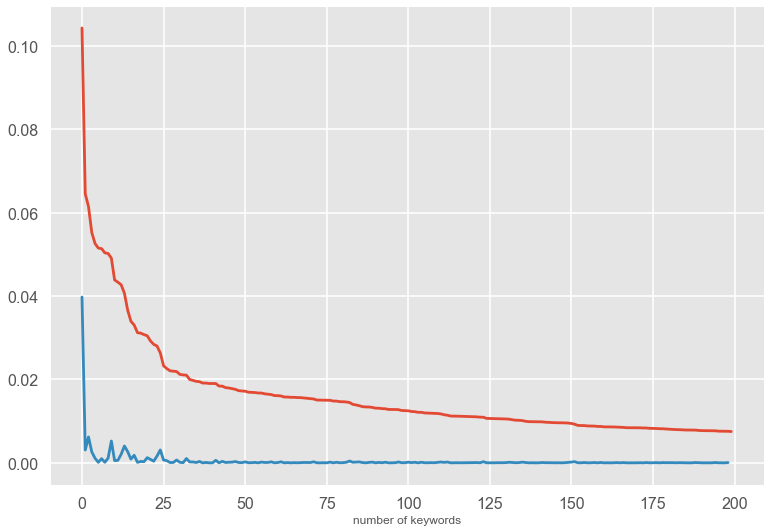

In [20]:
# Approach 1: get average tfidf for engineering and extract top average key words
idx_eng = np.arange(len(df_nos_select))[(df_nos_select['supersuite']=='engineering').values]
tfidf_eng = np.mean(tfidfm[idx_eng,:],axis = 0)
print(tfidf_eng.shape)
# check whether there is any sort of knee in the number of relevant features
_, ws , fs = extract_top_words(tfidf_eng, feature_names_n, N=200)
plt.plot(ws)
plt.plot(np.abs(np.diff(ws)))
plt.xlabel('number of keywords')
_, ws , fs = extract_top_words(tfidf_eng, feature_names_n, N=25)
for w,f in zip(ws,fs):
    print(np.around(w,3),f)
    

In [21]:
# for each standard, check intersection of top keywords
top_terms_intersect = {}
for ix,name in enumerate(df_nos_eng.index):
    top_terms_intersect[name] = list(set(fs[:13]).intersection(top_terms_dict[name][:13]))
    if len(top_terms_intersect[name])>5:
        print(name,top_terms_intersect[name])
        

eciipsm05.pdf ['machine', 'engineering', 'component', 'specification', 'tool', 'material']
ecimpsic01.pdf ['control', 'engineering', 'component', 'systems', 'specification', 'installation', 'tool']
ecimpsic02.pdf ['control', 'engineering', 'component', 'systems', 'installation', 'tool']
ecimpsic06.pdf ['control', 'component', 'engineering', 'systems', 'specification', 'tool']
ecimpsic08.pdf ['control', 'test', 'engineering', 'systems', 'specification', 'maintenance']
ecimpsic09.pdf ['control', 'component', 'engineering', 'systems', 'specification', 'installation']
ecimpsic10.pdf ['control', 'component', 'engineering', 'systems', 'specification', 'installation']
ecimpsic13.pdf ['control', 'test', 'engineering', 'systems', 'specification', 'installation']
ecimpsic15.pdf ['control', 'engineering', 'systems', 'specification', 'maintenance', 'installation']
semae3042.pdf ['control', 'component', 'systems', 'installation', 'tool', 'system']
semae3043.pdf ['control', 'component', 'systems', '

/Users/stefgarasto/miniconda3/envs/nlp/lib/python3.6/site-packages/sklearn/feature_extraction/text.py:301: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['1', '@'] not in stop_words.
  'stop_words.' % sorted(inconsistent))


(6267, 25) <class 'numpy.ndarray'>
6267 6267


/Users/stefgarasto/miniconda3/envs/nlp/lib/python3.6/site-packages/ipykernel_launcher.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/Users/stefgarasto/miniconda3/envs/nlp/lib/python3.6/site-packages/ipykernel_launcher.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


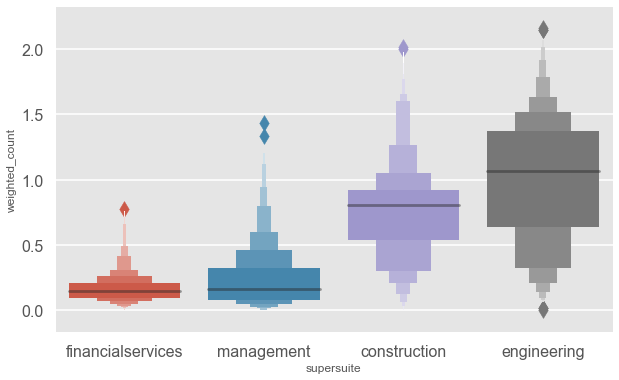

In [22]:
# obtain a value for "engineering-ness" using the top keywords from the average tfidf
# build a counter using the top keywords as vocabulary
from sklearn.feature_extraction.text import CountVectorizer
count_vec = CountVectorizer(vocabulary = fs, stop_words = stopwords0, tokenizer=tokenize_asis,
                                lowercase = False)#,
#                                max_df = params['tfidf_max'], 
#                                min_df = params['tfidf_min'])
count_data = count_vec.fit_transform(textfortoken).toarray()
print(count_data.shape, type(count_data))

weighted_count = []
fs2 = dict(zip(fs,ws))
for _, row in pd.DataFrame(count_data, columns=count_vec.get_feature_names()).iterrows():
    wc = sum(np.log(count + 1)*fs2[term] for term, count in row.iteritems() if count > 0)
    weighted_count.append(wc)
weighted_count = np.array(weighted_count)
#plt.plot(weighted_count)
print(len(weighted_count), len(df_nos_select))
df_nos_select['weighted_count'] = weighted_count
df_nos_eng['weighted_count'] = df_nos_select['weighted_count'][df_nos_select['supersuite']=='engineering']
plt.figure(figsize = (10,6))
sns.boxenplot(y = df_nos_select['weighted_count'], x = df_nos_select['supersuite'])



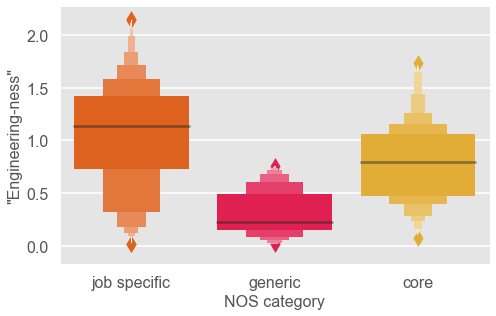

In [35]:
# now plot engineering-ness by NOS category
f = plt.figure(figsize = (7,4.5))
sns.boxenplot(data = df_nos_select[df_nos_select['supersuite']=='engineering'], y = 'weighted_count', 
             x = 'NOSCategory', palette = [nesta_colours[t] for t in [3,1,0]])
plt.ylabel('\"Engineering-ness\"', fontsize = 16)
plt.xlabel('NOS category', fontsize = 16)
# again, generic NOS seem to have a low engineering value
plt.tight_layout()
plt.savefig(os.path.join(output_dir, 'engineeringness_across_categories.png'))

In [24]:
stop

NameError: name 'stop' is not defined

In [ ]:
# check standards with highest similarity with average engineering
dist_from_eng = distance.cdist(tfidfm[idx_eng,:].todense(), tfidf_eng, metric = 'cosine')
print(type(dist_from_eng),dist_from_eng.shape)
sorted_by_eng_idx = np.argsort(dist_from_eng.ravel())
sorted_by_eng = df_nos_select[df_nos_select['supersuite']=='engineering'].index.values[sorted_by_eng_idx]
print(sorted_by_eng[:10],sorted_by_eng_idx[:10],dist_from_eng[sorted_by_eng_idx[:10]])
print()
print(fs)
for t in sorted_by_eng[:10]:
    print()
    print(new_top_terms_dict[t])
plt.plot(dist_from_eng[sorted_by_eng_idx])


In [ ]:
# get the cosine similarity matrix, turn it into a graph and compute centrality
pairwise_eng = distance.pdist(tfidfm[idx_eng].todense(), metric = 'cosine')
nx_graph = nx.from_numpy_array(1 - distance.squareform(pairwise_eng))

df_nos_eng['avg similarity'] = 1 - np.mean(distance.squareform(pairwise_eng),axis = 0)


In [ ]:
centralities = np.fromiter(nx.degree_centrality(nx_graph).values(), dtype = np.float32)
th_counter = 1
for th in np.arange(0.1,1,.1):
    M = 1 - distance.squareform(pairwise_eng)
    M = M * (M>th)
    tmp = np.fromiter(nx.degree_centrality(nx.from_numpy_array(M)).values(), dtype = np.float32)
    centralities = centralities + tmp
    th_counter += 1
centralities = centralities/th_counter
plt.plot(centralities)
ranked_nos0 = sorted(((centralities[i],s) for i,s in enumerate(df_nos_eng.index)), reverse=True)
df_nos_eng['centralities'] = centralities


In [ ]:
sns.boxenplot(y = df_nos_eng['centralities'], x = df_nos_eng['NOSCategory'])
#plt.hist(centralities[~(df_nos_eng['NOSCategory']=='generic')])
#plt.hist(centralities[df_nos_eng['NOSCategory']=='generic'])


In [ ]:
sns.boxenplot(y = df_nos_eng['avg similarity'], x = df_nos_eng['NOSCategory'])


In [ ]:
# TODO: 2D plot: engineering-ness vs centrality, coloured by NOSCategory (add a colour for nan as well?). 
# Where are the generic NOS??
plt.figure(figsize = (10,8))
sns.scatterplot(data= df_nos_eng, x = 'weighted_count',y='avg similarity', hue = 'NOSCategory',alpha = 0.5)
# note that it makes sense that the two variables are correlated. I'm taking as the engineering terms, 
# those terms that, on average, appear more often. This also means that NOS containing these terms the most are more
# central


In [ ]:
[t[1] for t in ranked_nos0[:20]]


In [ ]:
# Now use the cosine similarity graph to compute page rank scores
# (techinique taken from summarising texts)
t0 = time.time()
scores = nx.pagerank(nx_graph)
print_elapsed(t0,'implementing page rank')
ranked_sentences = sorted(((scores[i],s) for i,s in enumerate(df_nos_eng.index)), reverse=True)


In [ ]:
print([t[1] for t in ranked_sentences[:20]])


In [ ]:
# just try to plot a small portion of the graph
t0 = time.time()
M = 1 - distance.squareform(pairwise_eng)#[:1000,:1000]
M = M * (M>0.6)
node_list = np.where(np.sum(M,axis = 0)>1)[0]
tmp = np.array((df_nos_eng['NOSCategory']=='generic').values, dtype = np.float32)[node_list]#[:1000]
nx.draw(nx.from_numpy_array(M), node_color = tmp, cmap=plt.get_cmap('viridis'), nodelist = list(node_list),
       alpha= 0.1)
print_elapsed(t0, 'drawing graph')



In [ ]:
def count_occupations(x):
    if isinstance(x, str):
        return len(x.split(';'))
    elif isinstance(x, list):
        x = ''.join(x)
        return len(x.split(';'))
    else:
        print(x)
        return np.nan
def list_occupations(x):
    if isinstance(x, str):
        return x.split(';')
    elif isinstance(x, list):
        x = ''.join(x)
        return x.split(';')
    else:
        print(x)
        return np.nan
df_nos_eng['Occupations list'] = df_nos_eng['Occupations'].map(list_occupations)
df_nos_eng['Occupations N'] = df_nos_eng['Occupations list'].map(len)



In [ ]:
df_nos_eng[['Occupations list','NOSCategory','NOS Title','Occupations N']][df_nos_eng['Occupations N']>7]



In [ ]:
df_nos_eng[['NOS Title','NOSCategory']][df_nos_eng['Occupations list'].map(lambda x: 'engineering' in x)]
df_nos_eng[['NOS Title','Occupations list','All_suites']][df_nos_eng['NOSCategory']=='generic']



In [ ]:
df_nos_eng['NOSCategory'].isnull().sum(), len(df_nos_eng)


## Get TFIDF for engineering suites

In [ ]:
paramss = {}
paramss['ngrams'] = 'uni'
paramss['pofs'] = pofs #'nv'
paramss['tfidf_min'] = 2
paramss['tfidf_max'] = 0.4

paramss['bywhich'] = 'suites' #'docs' #'suites'
paramss['mode'] = 'combinedtfidf' #'tfidf' #'meantfidf' #'combinedtfidf' #'meantfidf'
# define the transform: this one can easily be the same for both 
# keywords and the clustering
tfidf_s = define_tfidf(paramss, stopwords0)

# get the transform from the whole NOS corpus
FULL_CORPUS = True
if FULL_CORPUS:
    tfidfm_s, feature_names_s, tfidf_s, textfortoken_s = get_tfidf_matrix(
            paramss, df_nos, tfidf_s, col = 'pruned_lemmas')
    suite_names = list(df_nos.groupby('One_suite').groups.keys())
    # note that all_matches['Engineering'] contains the indices corresponding to engineering suites
    tfidfm_s_eng = tfidfm_s[all_matches['Engineering']]
else:
    #df_nos_select = df_nos[df_nos['supersuite']=='engineering']
    tfidfm_s_eng, feature_names_s, tfidf_s, _ = get_tfidf_matrix(
            paramss, df_nos[df_nos['supersuite']=='engineering'], tfidf_s, col = 'pruned_lemmas')
    suite_names = list(df_nos[df_nos['supersuite']=='engineering'].groupby('One_suite').groups.keys())


print('Number of features: {}'.format(len(feature_names_s)))
N = 2000
print('Some features:')
print(feature_names_s[N:N+100:3])
print('*'*70)



# In[77]:

# first transform via tfidf all the NOS in one supersuite because you need the top keywords
#textfortoken = df_nos_select['pruned_lemmas']
#tfidfm_s = tfidf_s.transform(textfortoken)


In [ ]:
# Compute pairwise difference matrix between suites
#tfidfm_s_eng = tfidfm_s.todense()[np.array(all_matches['Engineering']),:]
pairwise_eng_suites = distance.squareform(distance.pdist(tfidfm_s_eng.todense(),
                                     metric= 'cosine'))
print(pairwise_eng_suites.shape)
all_matches_eng_dict = dict(zip(all_match_names['Engineering'], range(len(all_matches['Engineering']))))
# print an example
pairwise_eng_suites[all_matches_eng_dict['marine engineering suite 2'],
                    all_matches_eng_dict['marine engineering suite 3']]
plt.figure(figsize = (20,20))
sns.heatmap(pairwise_eng_suites, xticklabels = all_match_names['Engineering'], 
            yticklabels = all_match_names['Engineering'])


In [ ]:
#print(all_match_names['Engineering'])

pairwise_eng_suites[all_matches_eng_dict['marine engineering suite 3'],
                    all_matches_eng_dict['marine engineering suite 3']]
suite_here = 'aeronautical engineering suite 3'
_,_,a = extract_top_words(tfidfm_s_eng.todense()[all_matches_eng_dict[suite_here],:],
                          feature_names_s)
print(suite_here,a)


In [ ]:
pairwise_suites_by_nos = np.empty_like(distance.squareform(pairwise_eng))
N_eng = pairwise_suites_by_nos.shape[0]
t0 = time.time()
for ix1 in range(N_eng):
    suite1 = df_nos_eng['One_suite'].iloc[ix1]
    for ix2 in range(ix1,N_eng):
        suite2 = df_nos_eng['One_suite'].iloc[ix2]
        pairwise_suites_by_nos[ix1,ix2] = pairwise_eng_suites[all_matches_eng_dict[suite1],
                    all_matches_eng_dict[suite2]]
        pairwise_suites_by_nos[ix2,ix1] = pairwise_suites_by_nos[ix1,ix2]
print_elapsed(t0,'computing suite similarity nos by nos')
sns.heatmap(pairwise_suites_by_nos)


In [ ]:
# get the cosine similarity matrix between NOS, multiply by the difference between the NOS' suites
# That is, if two NOS are very similar but they belong to the same suite, then we don't really care
# Turn the modified similarity matrix into a graph and compute centrality
t0  = time.time()
pairwise_eng2 = distance.squareform(distance.pdist(tfidfm[idx_eng].todense(), metric = 'cosine'))

print_elapsed(t0, 'computing NOS distance matrix')
N_eng = pairwise_eng2.shape[0]
M = (1 - pairwise_eng2) * pairwise_suites_by_nos
df_nos_eng['avg similarity2'] = np.mean(M , axis = 0)

#for ix1 in range(N_eng):
#    suite1 = df_nos_eng['One_suite'].iloc[ix1]
#    for ix2 in range(ix1,N_eng):
#        suite2 = df_nos_eng['One_suite'].iloc[ix2]
#        mult = pairwise_eng_suites[all_matches_eng_dict[suite1],
#                    all_matches_eng_dict[suite2]]
#        M[ix1,ix2] *= mult
#        M[ix2,ix1] = M[ix1,ix2]
        
# first computation with matrix as it is
nx_graph = nx.from_numpy_array(M)

centralities2 = np.fromiter(nx.degree_centrality(nx_graph).values(), dtype = np.float32)
th_counter = 1
for th in np.arange(0.1,1,.1):
    #M = M * (M>.2)
    tmp = np.fromiter(nx.degree_centrality(nx.from_numpy_array(M * (M>th))).values(), dtype = np.float32)
    centralities2 = centralities2 + tmp
    th_counter += 1
centralities2 = centralities2/th_counter
plt.plot(centralities2)
plt.plot('centralities after accounting for suites similarities')
ranked_nos2 = sorted(((centralities2[i],s) for i,s in enumerate(df_nos_eng.index)), 
                     reverse=True)
df_nos_eng['centralities2'] = centralities2


In [ ]:
ranked_nos2[:20]


In [ ]:
plt.scatter(df_nos_eng['centralities'],df_nos_eng['centralities2'])


In [ ]:
sns.boxenplot(data = df_nos_eng, y = 'centralities2', x = 'NOSCategory')


In [ ]:
sns.boxenplot(data = df_nos_eng, y = 'avg similarity2', x = 'NOSCategory')


In [ ]:
print('The two centralities for generic NOS')
df_nos_eng[['centralities','centralities2']][df_nos_eng['NOSCategory']=='generic']


In [ ]:
# Now use the cosine similarity graph to compute page rank scores
# (techinique taken from summarising texts)
t0 = time.time()
scores2 = nx.pagerank(nx.from_numpy_array(M))
print_elapsed(t0,'implementing page rank')
ranked_sentences2 = sorted(((scores2[i],s) for i,s in enumerate(df_nos_eng.index)), reverse=True)


In [ ]:
for t in ranked_sentences2[-80:]:
    if (df_nos_eng['NOSCategory'].loc[t[1]]!='job specific'):
        print(df_nos_eng[['URN','NOS Title','NOSCategory','One_suite']].loc[t[1]].values)
        print()
        

In [ ]:
#Functions for fitting random forest model

def dropcol_importances(rf, X_train, y_train):
    rf_ = clone(rf)
    rf_.random_state = 999
    rf_.fit(X_train, y_train)
    baseline = rf_.oob_score_ #performance including all columns
    imp = []
    for i, col in enumerate(X_train.columns):
        X = X_train.drop(col, axis=1)
        rf_ = clone(rf)
        rf_.random_state = 999
        rf_.fit(X, y_train)
        o = rf_.oob_score_ #performance when removing a column. 
        # If the column is important, performance should decrease (o < baseline --> baseline - o > 0)
        imp.append(baseline - o)
    imp = np.array(imp)
    I = pd.DataFrame(
            data={'Feature':X_train.columns,
                  'Importance':imp})
    I = I.set_index('Feature')
    I = I.sort_values('Importance', ascending=True)
    return I, baseline


def get_predictive_terms(df, bin_data, bin_features, route, n, m = 3, STRATEGY = 'sequential'):
    is_route = df.supersuite == route
    positive = bin_data[is_route]
    _negative = bin_data[~is_route]
    size = positive.shape[0]
    y=[1]*size + [0]*size
    print(route, "-->", size)
    
    importances = []
    baselines = []
    if STRATEGY == 'sequential':
        # permute the array of the negative indices
        _negative = np.random.permutation(_negative)
        # compute the distance in indices between consecutive windows
        skip_step = np.floor((_negative.shape[0] - size)/n).astype(np.int64)
    for i in range(0, n):
        print('Building predictive model number {}'.format(i+1))
        if STRATEGY == 'sequential':
            random_idx = np.arange(i*skip_step, i*skip_step + size)
        else:
            random_idx = np.random.choice(_negative.shape[0], size=size, replace=False)
        negative = _negative[random_idx]
        X=np.vstack([positive, negative])
        rf = RandomForestClassifier(max_depth=3, n_estimators=100, oob_score=True, n_jobs = -1)
        rf.fit(X, y)

        # Build dataframe only with used columns
        X_train = pd.DataFrame(X, columns=bin_features)
        drop_cols = X_train.columns[rf.feature_importances_ == 0.0]
        X_train.drop(drop_cols, axis=1, inplace=True)
        
        I, baseline = dropcol_importances(rf, X_train, y)
        baselines.append(baseline)
        importances.append(I)
        
    df_imp = pd.concat(importances, axis=1, sort=False)
    df_imp_out = copy.deepcopy(df_imp)
    drop_rows = pd.isnull(df_imp).apply(np.sum, axis = 1)
    df_imp[pd.isnull(df_imp)] = 0.0
    
    # eliminate features that appear in less than 3 random forest classifiers
    #drop_rows = df_imp.apply(lambda x: (x>0).sum()>2, axis =1)
    df_imp = df_imp[drop_rows<(n-m+1)]
    keywords_mean = df_imp.apply(np.mean, axis=1).sort_values(ascending=False)
    th = 1e-5
    return dict(keywords_mean[keywords_mean > th]), dict(keywords_mean[(keywords_mean <= th) & 
                                                                       (keywords_mean >= 0)]), df_imp_out, baselines


In [ ]:
bin_vec = TfidfVectorizer(tokenizer=tokenize_asis,
                                lowercase = False,
                                stop_words=stopwords,
                                max_df = 0.4, 
                                min_df = 3)
#CountVectorizer(binary=True, stop_words = stopwords0, tokenizer=tokenize_asis, lowercase=False)
bin_data = bin_vec.fit_transform(df_nos['pruned_lemmas']).toarray()
bin_features = bin_vec.get_feature_names()
    
# extract the best predictors for engineering NOS
importances = {}
scores = {}
out_data = {}
unimportances = {}
for super_suite in set(df_nos_select.supersuite):
    print(super_suite)
    if super_suite != 'engineering':
        # keep the structure, but for now analyse engineering only
        continue
    t0 = time.time()
    keywords, keywords_unimportant, df_imp_out, baselines = get_predictive_terms(df_nos, bin_data, 
                                                                      bin_features, super_suite, n=10, m=5)

    importances[super_suite] = keywords
    unimportances[super_suite] = keywords_unimportant
    count_vec = CountVectorizer(vocabulary=keywords.keys(), stop_words = stopwords0, 
                                tokenizer=tokenize_asis, lowercase=False)
    count_data = count_vec.fit_transform(df_nos_select['pruned_lemmas']).toarray()
    print_elapsed(t0, 'computing key predictors for engineering NOS')
    
    weighted_count = []
    for _, row in pd.DataFrame(count_data, columns=count_vec.get_feature_names()).iterrows():
        wc = sum(np.log(count + 1)*importances[super_suite][term] for term, count in row.iteritems() if count > 0)
        weighted_count.append(wc)
    weighted_count = np.array(weighted_count)

    #count_data[count_data > 0] = 1

    corpus_length = np.array([len(doc) for doc in df_nos_select['pruned_lemmas']])
    digitalness = weighted_count/corpus_length

    _df = df_nos_select.copy()
    _df[super_suite] = digitalness #- np.median(digitalness)

    #approved = _df.Status == "Approved for delivery"


    score = {group: grouped[super_suite].median()
              for group, grouped in _df.groupby("supersuite")}#[approved].groupby("supersuite")}
    order = [route for route, score in Counter(score).most_common()]
    scores[super_suite] = score

    fig, ax = plt.subplots(figsize=(10,6))
    ax = sns.boxplot(x=super_suite, y="supersuite", 
                     data=_df, #[_df.Status == "Approved for delivery"], 
                     orient="h", order=order,
                     palette="Paired", ax=ax)

    ax.set_xlabel(f"'{super_suite.replace(' ','-').replace(',','').lower()}-ness' of NOS description")
    ax.set_ylabel("NOS super-suite")
    #ax.set_xlim(-0.003, 0.01)
    ax.set_title(super_suite)
    #plt.savefig(f"{route}-{int(stop_pc*100)}.png", bbox_inches = "tight")        

    #out_data[super_suite] = _df
    #out_data[super_suite].sort_values(route, ascending=False)[["Title", "Super-suite", super_suite]].to_csv(
    #    f"{super_suite.replace(' ','-').replace(',','').lower()}ness-{int(stop_pc*100)}.csv", index=False)

print()
for route, imps in importances.items():
    print(route, "-->", [k for k, v in Counter(imps).most_common(20)])
    print()

#print([out_data, scores, importances, unimportances, stop_words])
#check semae3002


In [ ]:
# extract the value of engineering-ness only for engineering NOS
sns.boxenplot(data= _df[_df['supersuite']=='engineering'], x = 'NOSCategory', y = 'engineering')


In [ ]:
plt.figure(figsize = (10,8))
sns.scatterplot(_df['engineering'][_df['supersuite']=='engineering']*1e3,df_nos_eng['avg similarity2'], 
                hue = df_nos_eng['NOSCategory'],alpha =0.5)


In [ ]:
# print NOS with lowest engineering-ness
print(_df[_df['supersuite']=='engineering'].sort_values('engineering')['NOS Title'].iloc[:20].values)



In [ ]:
# print NOS with highest engineering-ness
_df[_df['supersuite']=='engineering'].sort_values('engineering',
                                                ascending= False)['NOS Title'].iloc[:20].values


In [ ]:
baselines


In [ ]:
Counter(importances['engineering']).most_common()


In [ ]:
# join with df_nos_eng
df_nos_eng['engineeringness'] = _df[_df['supersuite']=='engineering']['engineering']


## Working with word embeddings

In [ ]:
'''
Compute average word embedding for each NOS
'''
t0 = time.time()
we_p_st = {}
std_we_p_st = {}
counter = 0
for ix,k in enumerate(new_top_terms_dict):
    # limit this to engineering NOS:
    if df_nos_select['supersuite'].loc[k] == 'engineering':
        avg_features, full_features  = get_mean_vec(new_top_terms_dict[k], model, 
                                                  weights = new_top_weights_dict[k])
        we_p_st[k] = avg_features
        #full_we_p_st[k]= full_features
        deviation = distance.cdist(avg_features[np.newaxis,:], full_features, metric = 'cosine')[0]
        std_we_p_st[k] = np.mean(deviation)
        #if np.mean(deviation)>.51:
        #    print(df_nos_select['NOSCategory'].loc[k])
        #    print(deviation)

# In[ ]:


# add the best clusters to the nos dataframe
tmp = pd.DataFrame.from_dict(we_p_st, orient = 'index')
all_we_nb = range(len(avg_features))
all_we_cols = []
all_we_changes = {}
for col in all_we_nb:
    all_we_changes[col] = 'weighted_avg_we{}'.format(col)
    all_we_cols.append('weighted_avg_we{}'.format(col))

tmp = tmp.rename(columns = all_we_changes) #{col: 'weighted_avg_we{}'.format(col)})
if 'weighted_avg_we1' in df_nos_eng.columns:
    keep_columns = list(set(df_nos_eng.columns) - set(all_we_cols))
    df_nos_eng = df_nos_eng[keep_columns]
    #for col in all_we_nb:
    #    del df_nos_eng[col]
    #df_nos_eng = df_nos[df_nos['supersuite']=='engineering']
df_nos_eng = df_nos_eng.join(tmp) #[all_we_cols] = tmp[all_we_cols]
df_nos_eng = df_nos_eng.join(pd.DataFrame.from_dict(std_we_p_st, orient= 'index'))
df_nos_eng = df_nos_eng.rename(columns= {0: 'we_spread'})
print_elapsed(t0, 'computing average word embedding')

counter = 0
for ix in range(20,400):
    nos = df_nos_eng.index[ix]
    if df_nos_eng['NOSCategory'].loc[nos] == 'generic':
        print(nos)
        print(df_nos_eng.loc[nos]['NOS Title'])
        print(new_top_terms_dict[nos])
        print(deviation)
        print(model.similar_by_vector(we_p_st[nos]))
        print()
        counter+=1
    if counter>4:
        break


In [ ]:
sns.boxenplot(data = df_nos_eng, y = 'we_spread', x = 'NOSCategory')


In [ ]:
sns.scatterplot(data = df_nos_eng, x='we_spread', y='avg similarity', hue= 'NOSCategory', alpha = 0.5)
#plt.ylim([0,0.0005])

In [ ]:
# last thing: use the features gathered so far to build a classifier generic vs job specific vs core
# transferable NOS are any NOS that act like generic NOS - so that should include 
# a) job specific NOS that were developed independently but are still quite generic
# b) job specific NOS that were derived by making very minimal change to generic NOS
rf = RandomForestClassifier(max_depth=3, n_estimators=100, oob_score=True, n_jobs = -1, 
                            class_weight = 'balanced_subsample')
# get the features
features_to_use = ['weighted_count','avg similarity', 'avg similarity2', 'we_spread','engineeringness']
X = df_nos_eng[features_to_use].values
y = df_nos_eng['NOSCategory'].values
unlabeled = np.array([isinstance(t,float) for t in y])
# extract test set
X_test = X[unlabeled]
y_test = y[unlabeled]
# extract validation set
#from sklearn.model_selection import train_test_split
#X_train, X_val, y_train, y_val = train_test_split(X[~unlabeled], y[~unlabeled], test_size=0.20, random_state=42)
rf.fit(X[~unlabeled], y[~unlabeled])


In [ ]:
print('oob score: {:.4f}'.format(rf.oob_score_)) #(X_val,y_val))
for ix,feat in enumerate(features_to_use):
    print('{}: {:.4f}'.format(feat, rf.feature_importances_[ix]))

In [ ]:
y_pred = rf.predict(X)

In [ ]:
pd.DataFrame(y_pred)[0].value_counts()

In [ ]:
df_nos_eng['NOSCategory'].value_counts()

In [ ]:
df_nos_eng['NOS Title'][y_pred=='generic'].values

In [ ]:
transferable_nos = df_nos_eng[y_pred=='generic']
transferable_nos.to_csv(os.path.join(output_dir, 'estimated_transferable_nos.csv'))